1. Load and Explore the Data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ML Task Data/twcs.csv')
df = df.sample(n = 10000, random_state=42)
print(df.head())
print(df.columns)
print(f"Dataset size after sampling: {len(df)} rows")


         tweet_id     author_id  inbound                      created_at  \
160535     192624        161253     True  Wed Oct 04 13:59:33 +0000 2017   
659248     738238        296574     True  Fri Oct 06 18:29:06 +0000 2017   
2250310   2414302  AppleSupport    False  Tue Nov 14 17:38:01 +0000 2017   
1640680   1793929        539096     True  Thu Oct 12 06:04:41 +0000 2017   
1933623   2088018        617376     True  Mon Nov 06 20:30:49 +0000 2017   

                                                      text response_tweet_id  \
160535   @161252 What's that egg website people talk about            192623   
659248   Why!🤷🏻‍♀️ #iOS11 @AppleSupport https://t.co/BX...            738237   
2250310  @693975 We can assist you. We recommend updati...           2414303   
1640680  @331912 @115955 Thats better than having an un...           1793928   
1933623  @VirginAmerica is probably one of the best air...           2088017   

         in_response_to_tweet_id  \
160535                  19

2. Clean the Text Data

In [3]:
import re
def clean_text(text):
    text = re.sub(r'http\S+', '', str(text))  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters and spaces
    text = text.lower().strip()  # Convert to lowercase and remove extra spaces
    return text
df['cleaned_text'] = df['text'].apply(clean_text)
print(df['cleaned_text'].head())  # Verify cleaning

160535              whats that egg website people talk about
659248                                  why ios applesupport
2250310    we can assist you we recommend updating to ios...
1640680    thats better than having an unstable connectio...
1933623    virginamerica is probably one of the best airl...
Name: cleaned_text, dtype: object


3. Install and Download NLTK Resources

In [4]:
import nltk
nltk.download('punkt')  # Download punkt tokenizer
nltk.download('punkt_tab')  # Download punkt_tab to fix LookupError
print("NLTK resources downloaded successfully.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


NLTK resources downloaded successfully.


4. Tokenize the Text

In [5]:
df['tokens'] = df['cleaned_text'].apply(nltk.word_tokenize)
print(df['tokens'].head())  # Verify tokenization

160535      [whats, that, egg, website, people, talk, about]
659248                              [why, ios, applesupport]
2250310    [we, can, assist, you, we, recommend, updating...
1640680    [thats, better, than, having, an, unstable, co...
1933623    [virginamerica, is, probably, one, of, the, be...
Name: tokens, dtype: object


5. Vectorize the Text

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for efficiency
X = vectorizer.fit_transform(df['cleaned_text'])  # Transform to TF-IDF matrix
print(X.shape)  # Check the shape of the resulting matrix

(10000, 5000)


Phase 2: ML Model for Predictive Analytics

1. Install AN DPREPARE Libraries

In [7]:
# Install required libraries (if not already installed from Phase 1)
!pip install scikit-learn pandas textblob

# Import libraries
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
print("Libraries imported successfully.")

Libraries imported successfully.


2. Create Labels for Issue Category and Churn

In [8]:
# Calculate sentiment polarity for each tweet
df['sentiment'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Create issue_category: positive, neutral, or negative based on sentiment
df['issue_category'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

# Create churn label: 1 (churn) for negative sentiment, 0 (no churn) otherwise
df['churn'] = df['sentiment'].apply(lambda x: 1 if x < 0 else 0)

# Verify the new columns
print(df[['cleaned_text', 'sentiment', 'issue_category', 'churn']].head())

                                              cleaned_text  sentiment  \
160535            whats that egg website people talk about        0.0   
659248                                why ios applesupport        0.0   
2250310  we can assist you we recommend updating to ios...        0.0   
1640680  thats better than having an unstable connectio...        0.5   
1933623  virginamerica is probably one of the best airl...        0.9   

        issue_category  churn  
160535         neutral      0  
659248         neutral      0  
2250310        neutral      0  
1640680       positive      0  
1933623       positive      0  


3. Train and Evaluate Issue Category Prediction Model

In [9]:
# Split data for issue category prediction
y = df['issue_category']  # Target: issue category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
model = LogisticRegression(max_iter=1000)  # Increase iterations for convergence
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(f"Issue Category Prediction Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report for Issue Category:")
print(classification_report(y_test, y_pred))

Issue Category Prediction Accuracy: 0.8295
Classification Report for Issue Category:
              precision    recall  f1-score   support

    negative       0.83      0.63      0.72       432
     neutral       0.79      0.94      0.86       811
    positive       0.88      0.83      0.85       757

    accuracy                           0.83      2000
   macro avg       0.83      0.80      0.81      2000
weighted avg       0.83      0.83      0.83      2000



4. Train and Evaluate Churn Prediction Model

In [10]:
# Split data for churn prediction
y_churn = df['churn']  # Target: churn
X_train_churn, X_test_churn, y_train_churn, y_test_churn = train_test_split(X, y_churn, test_size=0.2, random_state=42)

# Train Logistic Regression model for churn
churn_model = LogisticRegression(max_iter=1000)
churn_model.fit(X_train_churn, y_train_churn)

# Predict and evaluate
y_pred_churn = churn_model.predict(X_test_churn)
print(f"Churn Prediction Accuracy: {accuracy_score(y_test_churn, y_pred_churn)}")
print("Classification Report for Churn:")
print(classification_report(y_test_churn, y_pred_churn))

Churn Prediction Accuracy: 0.8645
Classification Report for Churn:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1568
           1       0.89      0.43      0.58       432

    accuracy                           0.86      2000
   macro avg       0.88      0.71      0.75      2000
weighted avg       0.87      0.86      0.85      2000



Generative AI Response System

1. Install and Import Transformers

In [11]:
# Install transformers (if not already installed)
!pip install transformers

# Import pipeline for text generation
from transformers import pipeline
print("Transformers library installed and imported successfully.")

Transformers library installed and imported successfully.


2. Initialize GPT-2

In [12]:
# Initialize GPT-2 text generation pipeline
generator = pipeline('text-generation', model='gpt2', device=0)  # Use GPU (device=0)
print("GPT-2 model loaded successfully.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


GPT-2 model loaded successfully.


3. Test Basic Response Generation

In [13]:
# Define a function to generate a basic response
def generate_response(query):
    response = generator(query, max_length=50, num_return_sequences=1, truncation=True)
    return response[0]['generated_text']

# Test with a sample query
sample_query = "My order is delayed, what should I do?"
print("Sample Query:", sample_query)
print("Generated Response:", generate_response(sample_query))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Sample Query: My order is delayed, what should I do?
Generated Response: My order is delayed, what should I do?

The following items are not currently available:


4. Integrate with Issue Category Model

In [14]:
# Define a function for tailored responses using the issue category model
def tailored_response(query):
    cleaned_query = clean_text(query)  # Clean the query using Phase 1 function
    category = model.predict(vectorizer.transform([cleaned_query]))[0]  # Predict category
    prompt = f"Customer query about {category} issue: {query}\nProvide a helpful response:"
    response = generator(prompt, max_length=50, num_return_sequences=1, truncation=True)
    return category, response[0]['generated_text']

# Test tailored response
print("Sample Query:", sample_query)
category, response = tailored_response(sample_query)
print(f"Predicted Category: {category}")
print(f"Tailored Response: {response}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Sample Query: My order is delayed, what should I do?
Predicted Category: neutral
Tailored Response: Customer query about neutral issue: My order is delayed, what should I do?
Provide a helpful response:


As long as you answer, I will be happy to take all your questions.


This will help you to get the best possible price.


If you have any questions about the price, post your question here.


If you have any question about the process (order placement, shipping, payment), please post here.


Data Visualization

Install and Import Visualization Libraries

In [15]:
# Install visualization libraries (if not already installed)
!pip install matplotlib seaborn

# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
print("Visualization libraries imported successfully.")

Visualization libraries imported successfully.


Plot Issue Category Distribution

<ipython-input-16-edcf0f0805c9>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=issue_counts.index, y=issue_counts.values, palette='viridis')


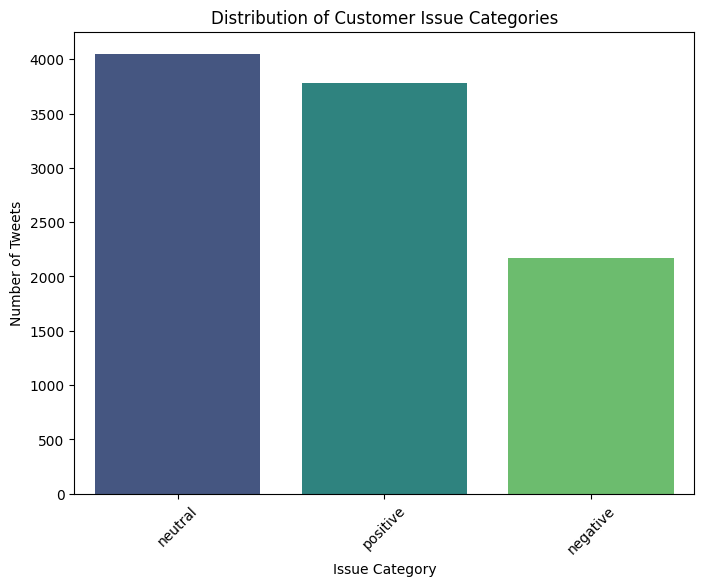

In [16]:
# Count issue categories
issue_counts = df['issue_category'].value_counts()

# Create bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=issue_counts.index, y=issue_counts.values, palette='viridis')
plt.xlabel('Issue Category')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Customer Issue Categories')
plt.xticks(rotation=45)
plt.show()

Plot Sentiment Distribution

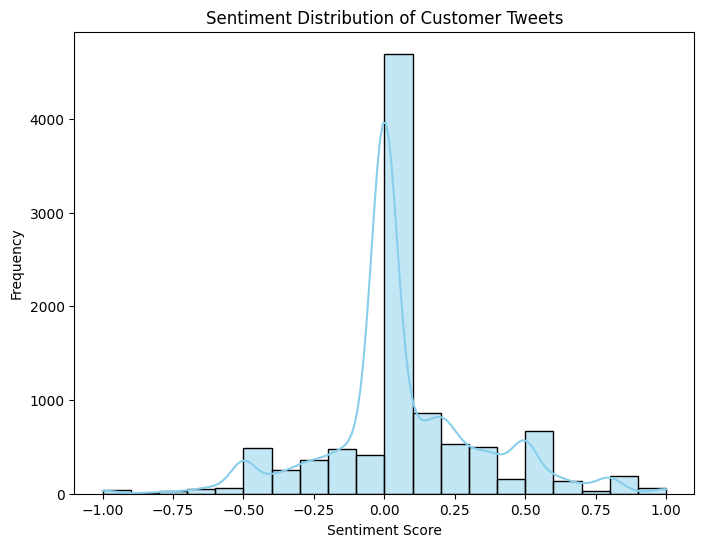

In [17]:
# Create histogram of sentiment scores
plt.figure(figsize=(8, 6))
sns.histplot(df['sentiment'], bins=20, color='skyblue', kde=True)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution of Customer Tweets')
plt.show()

Deploy API or Chatbot Interface

Install Required Libraries

In [18]:
# Install required libraries
!pip install streamlit pyngrok vaderSentiment
print("Streamlit, pyngrok, and vaderSentiment installed successfully.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.2 MB/s eta 0:00:00
Streamlit, pyngrok, and vaderSentiment installed successfully.


Authenticate ngrok

In [19]:
from pyngrok import ngrok
# Replace '2mX9...' with your actual ngrok auth token from https://dashboard.ngrok.com/get-started/your-authtoken
!ngrok authtoken 2xomQhnkWG1xrjnVQHCrS3ZIrko_2bYMvbiiDpgTFbLdoTUv8  # Replace with your actual token
print("ngrok authenticated successfully.")

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
ngrok authenticated successfully.


Save the Streamlit App Code

In [66]:
%%writefile app.py
import streamlit as st
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from transformers import pipeline
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('punkt_tab')

try:
    df = pd.read_csv('/content/drive/My Drive/ML Task Data/twcs.csv')
    df = df.sample(n=10000, random_state=42)
except FileNotFoundError:
    st.error("Error: twcs.csv not found.")
    st.stop()

def clean_text(text):
    text = re.sub(r'http\S+', '', str(text))
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower().strip()
    return text
df['cleaned_text'] = df['text'].apply(clean_text)
df['cleaned_text'] = df['cleaned_text'].fillna('')

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_text'])
df['sentiment'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['issue_category'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')
model = LogisticRegression(max_iter=1000)
model.fit(X, df['issue_category'])

generator = pipeline('text-generation', model='gpt2', device=0)
analyzer = SentimentIntensityAnalyzer()

def tailored_response(query):
    print(f"Raw query input (length {len(query)}): '{query}'")
    cleaned_query = clean_text(query)
    vader_scores = analyzer.polarity_scores(query)
    compound = vader_scores['compound']
    print(f"VADER compound score: {compound}")
    category = 'positive' if compound > 0.05 else 'negative' if compound < -0.1 else 'neutral'
    if category == 'neutral':
        negative_indicators = ["not", "hasn’t", "delayed", "lost", "damaged", "disappointed"]
        if any(ind in query.lower() for ind in negative_indicators):
            category = 'negative'
        else:
            category = model.predict(vectorizer.transform([cleaned_query]))[0]
    prompt = f"{query} - Respond with a short, empathetic support message specific to the issue."
    response = generator(
        prompt,
        max_length=50,
        num_return_sequences=1,
        truncation=True,
        temperature=0.5,
        top_k=40,
        no_repeat_ngram_size=2
    )
    generated_text = response[0]['generated_text']
    print(f"Raw generated text: {generated_text}")
    cleaned_response = generated_text.replace(prompt, "").strip()
    negative_keywords = ["package", "lost", "order", "delayed", "product", "broken", "arrived", "disappointed", "damaged"]
    positive_keywords = ["love", "thank", "fast", "great", "amazing"]
    relevant_keywords = negative_keywords if category == "negative" else positive_keywords
    is_relevant = any(kw in cleaned_response.lower() for kw in relevant_keywords)
    if len(cleaned_response.split()) < 5 or not is_relevant or '‡' in cleaned_response:
        if category == "negative":
            issue = "lost package" if "lost" in query.lower() or "arrived" in query.lower() else "delay" if "delayed" in query.lower() else "damaged item" if "damaged" in query.lower() else "broken product" if "broken" in query.lower() else "disappointment" if "disappointed" in query.lower() else "issue"
            cleaned_response = f"We're sorry for the {issue}. Please provide your order number."
        else:
            cleaned_response = "Thank you for your kind words! We're glad you're happy."
    return category, cleaned_response

st.title('Customer Support Automation Chatbot')
st.write("Enter a customer query to get an automated response.")
query = st.text_input('Enter your query (e.g., "My order is delayed"):', key="query_input")
if st.button("Submit"):  # Add button to trigger response
    if query is None or len(query.strip()) == 0:
        st.write("**Predicted Issue Category**: Unknown")
        st.write("**Response**: Please enter a valid query.")
    else:
        category, response = tailored_response(query)
        st.write(f"**Predicted Issue Category**: {category}")
        st.write(f"**Response**: {response}")

st.subheader("Issue Trends")
import matplotlib.pyplot as plt
import seaborn as sns
issue_counts = df['issue_category'].value_counts()
fig, ax = plt.subplots()
sns.barplot(x=issue_counts.index, y=issue_counts.values, ax=ax)
ax.set_title("Customer Issue Distribution")
st.pyplot(fig)

Overwriting app.py


Start Streamlit and Create Public URL

In [67]:
from pyngrok import ngrok
import subprocess

# Kill existing ngrok and Streamlit processes
!pkill ngrok
!pkill streamlit

# Start Streamlit in the background
subprocess.Popen(['streamlit', 'run', 'app.py'])

# Create a public URL with ngrok
ngrok.set_auth_token('2xomQhnkWG1xrjnVQHCrS3ZIrko_2bYMvbiiDpgTFbLdoTUv8')  # Replace with your actual ngrok auth token
public_url = ngrok.connect(8501, bind_tls=True)  # Use HTTPS
print(f"Streamlit app is running at: {public_url}")

Streamlit app is running at: NgrokTunnel: "https://776e-35-231-78-35.ngrok-free.app" -> "http://localhost:8501"
